# **LEWIS_RYLAN_NATHAN_FINAL_PROJECT**



Name: Rylan Nathan Lewis


Github Username: Rylannat


USC ID: 8358130873

# **Transfer Learning for Image Classification**

Importing the Packages

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import (ResNet50, ResNet101, EfficientNetB0, VGG16, DenseNet201)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Exploration and Preprocessing

In [4]:
dataset_path = "../data/Jute_Pest_Dataset/"

img_size = (224, 224)
batch_size = 5
epochs = 100
num_classes = 17
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "val"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "test"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names

Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


In [6]:
print(class_names)

['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']


# Transfer Learning

(i),(ii)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomCrop(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
])

train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
    .prefetch(AUTOTUNE)
)

(iii)

The convolutional base is basically a fixed feature extractor layer as its layers are frozen during the first training. There is an addition of a custom fully connected head consisting of a Global Average Pooling layer that is used to lessen the spatial dimensions, followed by Batch Normalization and Dropout layers (rate = 0.2) to improve regularization and to prevent overfitting. A 256-unit dense layer with ReLU activation and L2 regularization (1x10^-4) is used to capture high-level abstractions before the final softmax output layer, which returns the class probabilities of all target categories. The model is set up with the Adam optimizer and categorical cross-entropy loss, which is appropriate for multi-class classification problems.

In [9]:
def build_model(base_model_class):
    base_model = base_model_class(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(num_classes, activation="softmax")(x)

    model = Model(base_model.input, output)

    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

(iv)

In [ ]:
def train_model(model, model_name):

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} Training History")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

(v)

In [11]:
def evaluate_model(model, dataset, dataset_name):
    y_true = []
    y_pred_prob = []

    for x, y in dataset:
        y_true.append(y.numpy())
        y_pred_prob.append(model.predict(x, verbose=0))

    y_true = np.argmax(np.vstack(y_true), axis=1)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print(f"Evaluation metrics of {dataset_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    auc = roc_auc_score(
        tf.keras.utils.to_categorical(y_true, num_classes),
        y_pred_prob,
        multi_class="ovr"
    )
    print(f"AUC Score: {auc:.4f}")

Training ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1400 - loss: 3.0560
Epoch 1: val_loss improved from inf to 3.44051, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/ResNet50.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 325s 239ms/step - accuracy: 0.1400 - loss: 3.0558 - val_accuracy: 0.2058 - val_loss: 3.4405
Epoch 2/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2012 - loss: 2.6394
Epoch 2: val_loss improved from 3.44051 to 2.77446, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/ResNet50.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2012 - loss: 2.6393 - val_accuracy: 0.2639 - val_loss: 2.7745
Epoch 3/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2288 - loss: 2.5281
Epoch 3: val_loss improved from 2.77446 to 2.76246, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/ResNet50.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.2288 - loss: 2.5281 - val_accuracy: 0.2470 - val_loss: 2.7625
Epoch 4/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2438 - loss: 2.4911
Epoch 4: val_loss did not improve from 2.76246
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2438 - loss: 2.4911 - val_accuracy: 0.2276 - val_loss: 2.7662
Epoch 5/100
1285/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2566 - loss: 2.4398
Epoch 5: val_loss improved from 2.76246 to 2.65555, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/ResNet50.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2566 - loss: 2.4398 - val_accuracy: 0.2736 - val_loss: 2.6555
Epoch 6/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2573 - loss: 2.4213
Epoch 6: val_loss did not improve from 2.65555
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2573 - loss: 2.4214 - val_accuracy: 0.2300 - val_loss: 2.7486
Epoch 7/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2776 - loss: 2.4179
Epoch 7: val_loss did not improve from 2.65555
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2776 - loss: 2.4179 - val_accuracy: 0.2930 - val_loss: 2.8509
Epoch 8/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2697 - loss: 2.4202
Epoch 8: val_loss did not improve from 2.65555
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2697 - loss: 2.4202 - val_accuracy: 0.2857 - val_loss: 3.2473
Epoch 9/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2957 - loss: 2.3929
Epoch 9: val_lo

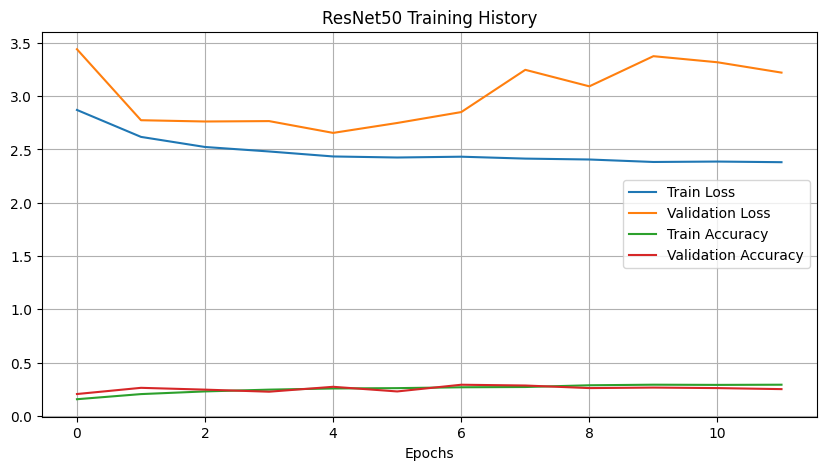

In [12]:
print("Training ResNet50")
resnet50 = build_model(ResNet50)
resnet50 = train_model(resnet50, "ResNet50")

In [ ]:
evaluate_model(resnet50, train_ds, "ResNet50 - Training")
evaluate_model(resnet50, val_ds, "ResNet50 - Validation")
evaluate_model(resnet50, test_ds, "ResNet50 - Test")

Evaluation metrics of ResNet50 – Training
                               precision    recall  f1-score   support

                Beet Armyworm       0.11      0.11      0.11       199
                  Black Hairy       0.34      0.33      0.34       309
                      Cutworm       0.29      0.23      0.26       399
                Field Cricket       0.40      0.31      0.35       392
                   Jute Aphid       0.23      0.44      0.31       530
                   Jute Hairy       0.21      0.11      0.14       414
                Jute Red Mite       0.43      0.41      0.42       457
              Jute Semilooper       0.47      0.32      0.38       372
            Jute Stem Girdler       0.58      0.65      0.62       281
             Jute Stem Weevil       0.42      0.43      0.42       676
                  Leaf Beetle       0.41      0.31      0.35       310
                     Mealybug       0.37      0.52      0.43       466
                    Pod Borer     

Training ResNet101
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1164 - loss: 3.1390
Epoch 1: val_loss improved from inf to 2.66640, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/ResNet101.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.1165 - loss: 3.1389 - val_accuracy: 0.2155 - val_loss: 2.6664
Epoch 2/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1801 - loss: 2.7164
Epoch 2: val_loss did not improve from 2.66640
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.1801 - loss: 2.7163 - val_accuracy: 0.1961 - val_loss: 2.7286
Epoch 3/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2101 - loss: 2.5940
Epoch 3: val_loss did not improve from 2.66640
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.2101 - loss: 2.5940 - val_accuracy: 0.2324 - val_loss: 2.7281
Epoch 4/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2210 - loss: 2.5497
Epoch 4: val_loss did not improve from 2.66640
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.2210 - loss: 2.5497 - val_accuracy: 0.2373 - val_loss: 2.7349
Epoch 5/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2214 - loss: 2.5073
Epoch 5: val_lo

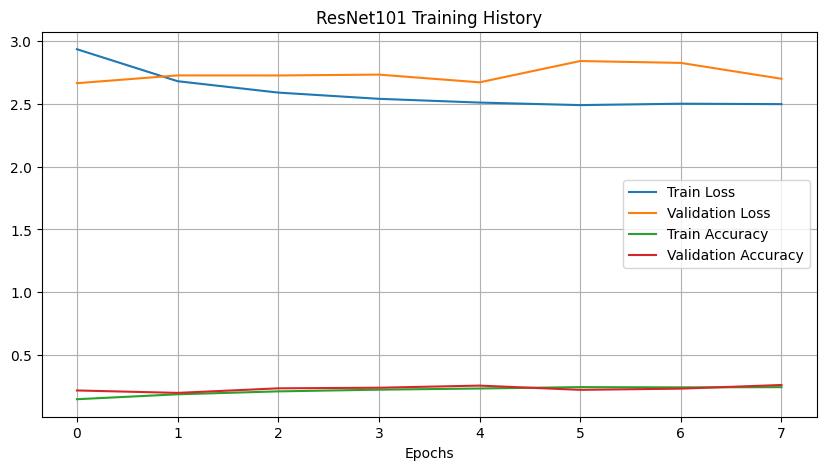

In [14]:
print("Training ResNet101")
resnet101 = build_model(ResNet101)
resnet101 = train_model(resnet101, "ResNet101")

In [ ]:
evaluate_model(resnet101, train_ds, "ResNet101 - Training")
evaluate_model(resnet101, val_ds, "ResNet101 - Validation")
evaluate_model(resnet101, test_ds, "ResNet101 - Test")

Evaluation metrics of ResNet101 – Training
                               precision    recall  f1-score   support

                Beet Armyworm       0.07      0.02      0.03       199
                  Black Hairy       0.28      0.28      0.28       309
                      Cutworm       0.25      0.12      0.16       399
                Field Cricket       0.31      0.20      0.24       392
                   Jute Aphid       0.19      0.47      0.27       530
                   Jute Hairy       0.25      0.03      0.06       414
                Jute Red Mite       0.15      0.12      0.13       457
              Jute Semilooper       0.27      0.34      0.30       372
            Jute Stem Girdler       0.39      0.64      0.49       281
             Jute Stem Weevil       0.21      0.28      0.24       676
                  Leaf Beetle       0.27      0.12      0.17       310
                     Mealybug       0.20      0.41      0.27       466
                    Pod Borer    

Training EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0738 - loss: 3.3681
Epoch 1: val_loss improved from inf to 2.94410, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/EfficientNetB0.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 85s 40ms/step - accuracy: 0.0738 - loss: 3.3680 - val_accuracy: 0.1743 - val_loss: 2.9441
Epoch 2/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0777 - loss: 3.0974
Epoch 2: val_loss improved from 2.94410 to 2.88718, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/EfficientNetB0.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.0777 - loss: 3.0974 - val_accuracy: 0.1719 - val_loss: 2.8872
Epoch 3/100
1288/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0710 - loss: 3.0361
Epoch 3: val_loss improved from 2.88718 to 2.83120, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/EfficientNetB0.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.0711 - loss: 3.0360 - val_accuracy: 0.1719 - val_loss: 2.8312
Epoch 4/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0840 - loss: 2.9866
Epoch 4: val_loss did not improve from 2.83120
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.0840 - loss: 2.9866 - val_accuracy: 0.1719 - val_loss: 2.8527
Epoch 5/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0824 - loss: 2.9623
Epoch 5: val_loss did not improve from 2.83120
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0824 - loss: 2.9623 - val_accuracy: 0.1719 - val_loss: 2.8914
Epoch 6/100
1285/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0765 - loss: 2.9394
Epoch 6: val_loss did not improve from 2.83120
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.0765 - loss: 2.9394 - val_accuracy: 0.1743 - val_loss: 2.8596
Epoch 7/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0923 - loss: 2.9193
Epoch 7: val_lo

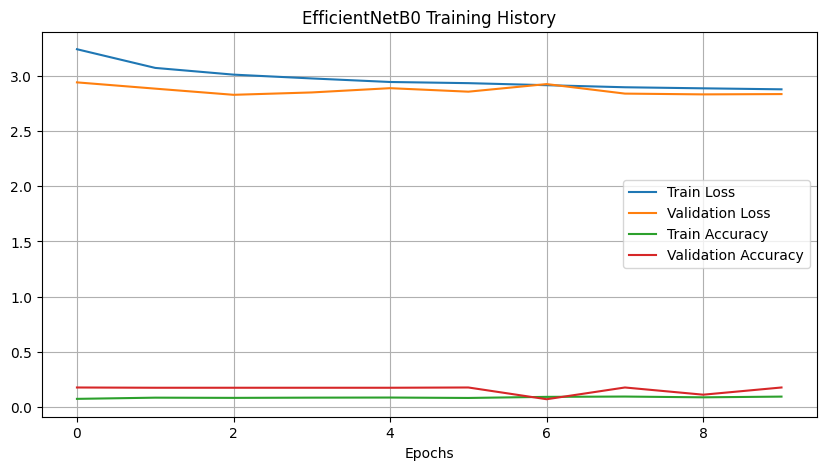

In [16]:
print("Training EfficientNetB0")
efficientnet = build_model(EfficientNetB0)
efficientnet = train_model(efficientnet, "EfficientNetB0")

In [ ]:
evaluate_model(efficientnet, train_ds, "EfficientNetB0 - Training")
evaluate_model(efficientnet, val_ds, "EfficientNetB0 - Validation")
evaluate_model(efficientnet, test_ds, "EfficientNetB0 - Test")

Evaluation metrics of EfficientNetB0 – Training
                               precision    recall  f1-score   support

                Beet Armyworm       0.00      0.00      0.00       199
                  Black Hairy       0.00      0.00      0.00       309
                      Cutworm       0.00      0.00      0.00       399
                Field Cricket       0.00      0.00      0.00       392
                   Jute Aphid       0.00      0.00      0.00       530
                   Jute Hairy       0.00      0.00      0.00       414
                Jute Red Mite       0.00      0.00      0.00       457
              Jute Semilooper       0.00      0.00      0.00       372
            Jute Stem Girdler       0.00      0.00      0.00       281
             Jute Stem Weevil       0.10      1.00      0.19       676
                  Leaf Beetle       0.00      0.00      0.00       310
                     Mealybug       0.00      0.00      0.00       466
                    Pod Bore

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation metrics of EfficientNetB0 – Validation
                               precision    recall  f1-score   support

                Beet Armyworm       0.00      0.00      0.00        40
                  Black Hairy       0.00      0.00      0.00        30
                      Cutworm       0.00      0.00      0.00        18
                Field Cricket       0.00      0.00      0.00        14
                   Jute Aphid       0.00      0.00      0.00        27
                   Jute Hairy       0.00      0.00      0.00         8
                Jute Red Mite       0.00      0.00      0.00        49
              Jute Semilooper       0.00      0.00      0.00         5
            Jute Stem Girdler       0.00      0.00      0.00         6
             Jute Stem Weevil       0.17      1.00      0.29        71
                  Leaf Beetle       0.00      0.00      0.00         9
                     Mealybug       0.00      0.00      0.00        35
                    Pod Bo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation metrics of EfficientNetB0 – Test
                               precision    recall  f1-score   support

                Beet Armyworm       0.00      0.00      0.00        20
                  Black Hairy       0.00      0.00      0.00        20
                      Cutworm       0.00      0.00      0.00        20
                Field Cricket       0.00      0.00      0.00        20
                   Jute Aphid       0.00      0.00      0.00        22
                   Jute Hairy       0.00      0.00      0.00        20
                Jute Red Mite       0.00      0.00      0.00        24
              Jute Semilooper       0.00      0.00      0.00        21
            Jute Stem Girdler       0.00      0.00      0.00        24
             Jute Stem Weevil       0.06      1.00      0.12        24
                  Leaf Beetle       0.00      0.00      0.00        24
                     Mealybug       0.00      0.00      0.00        24
                    Pod Borer   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3888 - loss: 2.1849
Epoch 1: val_loss improved from inf to 1.13497, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/VGG16.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3888 - loss: 2.1846 - val_accuracy: 0.6973 - val_loss: 1.1350
Epoch 2/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6155 - loss: 1.2842
Epoch 2: val_loss improved from 1.13497 to 1.05875, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/VGG16.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6155 - loss: 1.2841 - val_accuracy: 0.7312 - val_loss: 1.0588
Epoch 3/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6560 - loss: 1.1701
Epoch 3: val_loss improved from 1.05875 to 1.03085, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/VGG16.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6561 - loss: 1.1699 - val_accuracy: 0.7240 - val_loss: 1.0308
Epoch 4/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6941 - loss: 1.0662
Epoch 4: val_loss did not improve from 1.03085
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6941 - loss: 1.0662 - val_accuracy: 0.7215 - val_loss: 1.1067
Epoch 5/100
1284/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6984 - loss: 1.0340
Epoch 5: val_loss did not improve from 1.03085
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6984 - loss: 1.0339 - val_accuracy: 0.7312 - val_loss: 1.0801
Epoch 6/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7223 - loss: 1.0172
Epoch 6: val_loss did not improve from 1.03085
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7223 - loss: 1.0172 - val_accuracy: 0.7603 - val_loss: 1.1015
Epoch 7/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7225 - loss: 0.9687
Epoch 7: val_lo

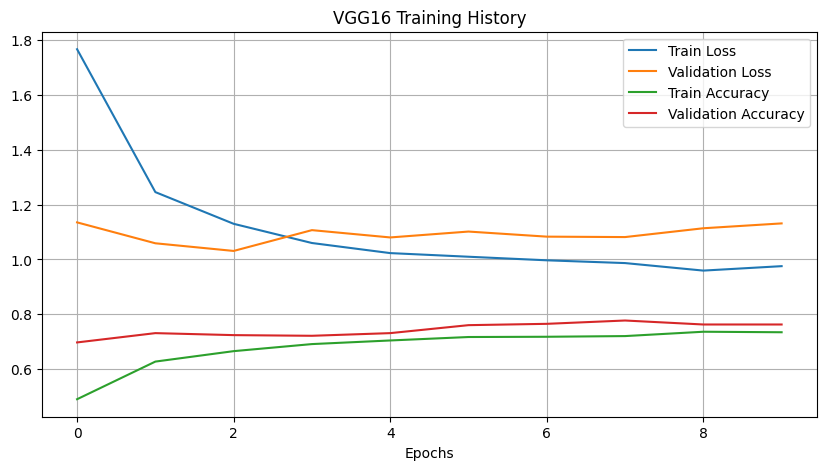

In [18]:
print("Training VGG16")
vgg16 = build_model(VGG16)
vgg16 = train_model(vgg16, "VGG16")

In [ ]:
evaluate_model(vgg16, train_ds, "VGG16 - Training")
evaluate_model(vgg16, val_ds, "VGG16 - Validation")
evaluate_model(vgg16, test_ds, "VGG16 - Test")

Evaluation metrics of VGG16 – Training
                               precision    recall  f1-score   support

                Beet Armyworm       0.70      0.59      0.64       199
                  Black Hairy       0.83      0.81      0.82       309
                      Cutworm       0.86      0.82      0.84       399
                Field Cricket       0.84      0.93      0.89       392
                   Jute Aphid       0.77      0.75      0.76       530
                   Jute Hairy       0.82      0.68      0.74       414
                Jute Red Mite       0.86      0.91      0.88       457
              Jute Semilooper       0.93      0.96      0.95       372
            Jute Stem Girdler       0.97      0.99      0.98       281
             Jute Stem Weevil       0.93      0.85      0.89       676
                  Leaf Beetle       0.95      0.96      0.96       310
                     Mealybug       0.85      0.90      0.88       466
                    Pod Borer       0

Training DenseNet201
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5978 - loss: 1.4672
Epoch 1: val_loss improved from inf to 0.58177, saving model to /content/drive/MyDrive/DSCI552/Model_checkpoints/DenseNet201.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 149s 78ms/step - accuracy: 0.5978 - loss: 1.4669 - val_accuracy: 0.8499 - val_loss: 0.5818
Epoch 2/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8183 - loss: 0.6527
Epoch 2: val_loss did not improve from 0.58177
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8183 - loss: 0.6526 - val_accuracy: 0.8596 - val_loss: 0.5879
Epoch 3/100
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8392 - loss: 0.6168
Epoch 3: val_loss did not improve from 0.58177
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8392 - loss: 0.6167 - val_accuracy: 0.8620 - val_loss: 0.5889
Epoch 4/100
1287/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8607 - loss: 0.5422
Epoch 4: val_loss did not improve from 0.58177
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.8607 - loss: 0.5423 - val_accuracy: 0.8692 - val_loss: 0.6111
Epoch 5/100
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8555 - loss: 0.5813
Epoch 5: val_l

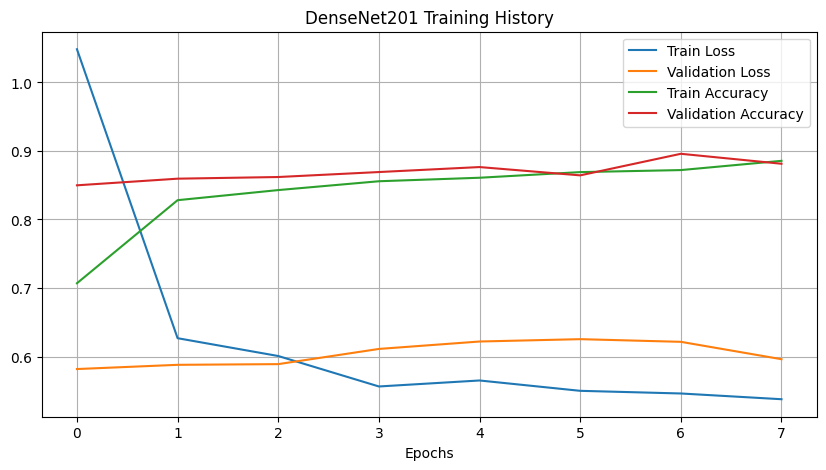

In [20]:
print("Training DenseNet201")
densenet = build_model(DenseNet201)
densenet = train_model(densenet, "DenseNet201")

In [ ]:
evaluate_model(densenet, train_ds, "DenseNet201 - Training")
evaluate_model(densenet, val_ds, "DenseNet201 - Validation")
evaluate_model(densenet, test_ds, "DenseNet201 - Test")

Evaluation metrics of DenseNet201 – Training
                               precision    recall  f1-score   support

                Beet Armyworm       0.86      0.67      0.75       199
                  Black Hairy       0.91      0.91      0.91       309
                      Cutworm       0.91      0.93      0.92       399
                Field Cricket       0.96      0.97      0.97       392
                   Jute Aphid       0.88      0.85      0.86       530
                   Jute Hairy       0.89      0.86      0.88       414
                Jute Red Mite       0.96      0.98      0.97       457
              Jute Semilooper       0.94      0.98      0.96       372
            Jute Stem Girdler       0.99      1.00      0.99       281
             Jute Stem Weevil       0.98      0.95      0.96       676
                  Leaf Beetle       0.97      0.99      0.98       310
                     Mealybug       0.94      0.97      0.95       466
                    Pod Borer  

# **CONCLUSION**

By looking at the figures that measure the performance of the models in the training, validation, and test sets, it is evident that **DenseNet201** is clearly above the other networks in the multi-class pest classification problem. It achieves the highest precision (0.93), recall (0.92), F1-score (0.92), and AUC (0.9970) on the test set, indicating that it is capable of strong feature generalization and discrimination. Its dense connectivity, which encourages effective feature reuse and stable gradient flow, and thus better adaptation to fine-grained pest textures and structures, can be credited for this outstanding performance.

VGG16 is a strong performer (test F1 ≈ 0.86, AUC 0.9899) but does not have skip connections which make feature propagation less efficient than in DenseNet201.

ResNet50 and ResNet101, though having residual links, are showing symptoms of underfitting and moderate AUCs (~0.82 and ~0.75) which is a probable reason for their suboptimal transfer learning adaptation to the smaller dataset.

EfficientNetB0 is the worst performer, indicating that its light-weighted configuration is a limiting factor for the feature richness that is required for high inter-class variability.

In short, DenseNet201 is able to strike an optimal balance between the depth of the architecture, parameter efficiency, and the adaptability of transfer learning, thus making it the most appropriate model for this task.

# **REFERENCES**

https://keras.io

https://builtin.com/data-science/transfer-learning

https://en.wikipedia.org/wiki/Batch_normalization